<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [2]:
image = Image.open("data/moon.jpg")
data = np.asarray(ImageOps.grayscale(image))

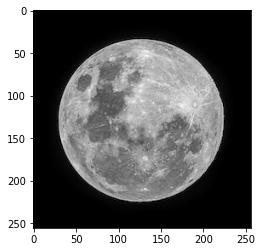

In [3]:
plt.imshow(data, cmap='gray')

In [4]:
img_size = 256
mesh = torch.stack(torch.meshgrid(torch.arange(img_size), torch.arange(img_size)), dim=-1)

In [5]:
x = mesh.view(-1, 2) / (img_size - 1)
y = torch.from_numpy(data).view(-1, 1).to(dtype=torch.float32) / 255

print(x.min(), x.max(), y.min(), y.max())

tensor(0.) tensor(1.) tensor(0.) tensor(0.9373)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  


In [6]:
class Sine(nn.Module):
    def __init__(self, w0=30):
        super(Sine, self).__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)


class Siren(nn.Module):
  def __init__(self, architecture=[2, 100, 100, 1], activation=Sine()):
        super(Siren, self).__init__()      
        self.architecture=architecture
        self.activation = activation
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1], architecture[i]))            
            arch.append(self.activation)
        self.hidden=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2], architecture[-1])
        
  def forward(self,f):            
        z=self.hidden(f)
        out=self.regressor(z)
        return out


In [7]:
Siren()

Siren(
  (activation): Sine()
  (hidden): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sine()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sine()
  )
  (regressor): Linear(in_features=100, out_features=1, bias=True)
)

In [8]:
num_epochs = 1000
lr = 0.01
batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Siren().to(device)
optim=torch.optim.SGD(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim,milestones=[250,500], gamma=0.1)
criterion = nn.MSELoss().to(device)

In [11]:
losses = []
for n in range(num_epochs):
  if n % 10 == 0 and n != 0:
    print(f'epoch {n} loss: {losses[-1]}')
  
  for i in range(img_size ** 2 // batch_size):
    x_samples = x[i * batch_size : (i + 1) * batch_size, :].to(device)
    y_samples = y[i * batch_size : (i + 1) * batch_size].to(device)
    pred = model(x_samples)
    loss = criterion(pred, y_samples)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

epoch 10 loss: 0.047053880989551544
epoch 20 loss: 0.04068835452198982
epoch 30 loss: 0.034914784133434296
epoch 40 loss: 0.03370478004217148
epoch 50 loss: 0.029632680118083954
epoch 60 loss: 0.02615644782781601
epoch 70 loss: 0.026726823300123215
epoch 80 loss: 0.025249820202589035
epoch 90 loss: 0.02207932434976101
epoch 100 loss: 0.020127270370721817
epoch 110 loss: 0.019975004717707634
epoch 120 loss: 0.019945373758673668
epoch 130 loss: 0.019141636788845062
epoch 140 loss: 0.01765342429280281
epoch 150 loss: 0.015888147056102753
epoch 160 loss: 0.014581550844013691
epoch 170 loss: 0.01425258256494999
epoch 180 loss: 0.014636583626270294
epoch 190 loss: 0.015101110562682152
epoch 200 loss: 0.015229618176817894
epoch 210 loss: 0.015015892684459686
epoch 220 loss: 0.014672667719423771
epoch 230 loss: 0.014376385137438774
epoch 240 loss: 0.014181089587509632
epoch 250 loss: 0.014060494489967823
epoch 260 loss: 0.01395978219807148
epoch 270 loss: 0.013830197975039482
epoch 280 loss: 0

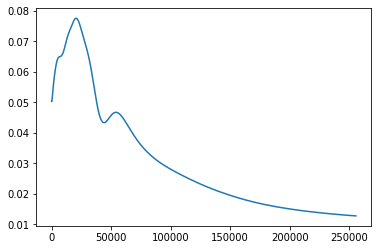

In [22]:
selected_epochs = [i for i in range(0, num_epochs * (img_size ** 2 // batch_size), batch_size)]
selected_losses = [losses[i] for i in range(0, len(losses), batch_size)]
plt.plot(selected_epochs, selected_losses)
plt.show()

In [37]:
def eval_res(model, res):
  mesh = torch.stack(torch.meshgrid(torch.arange(res), torch.arange(res)), dim=-1) / ( res - 1)
  x = mesh.view(-1, 2)
  model.eval()
  with torch.no_grad():
    pred_img = model(x.to(device)).view(res, res) 
  
  return pred_img.cpu().numpy()

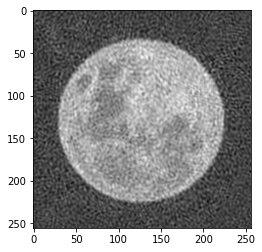

In [38]:
pred_img = eval_res(model, 256)
plt.imshow(pred_img, cmap='gray')
plt.show()

### Increase grid resolution

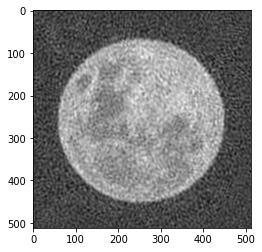

In [39]:
pred_img_512 = eval_res(model, 512)
plt.imshow(pred_img_512, cmap='gray')
plt.show()

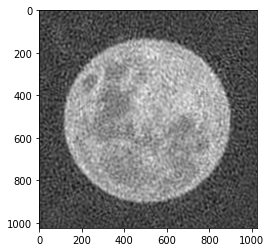

In [40]:
pred_img_1024 = eval_res(model, 1024)
plt.imshow(pred_img_1024, cmap='gray')
plt.show()